# Manual backprop with numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DenseLayer:

    def __init__(self, ni, no, act='relu'):
        self.w = np.random.randn(ni, no)
        self.b = np.zeros(no)
        self.act = act
    
    def forward(self,  x):
        out = x @ self.w + self.b
        if self.act == 'relu': 
            out = out.clip(min=0.)
        return out
    
    __call__ = forward

    def bwd(self, dout, out, x):
        dz = np.where(out>0, dout, 0) if self.act else dout
        dw = x.transpose() @ dz
        db = dz.sum(axis=0)
        dx = dz @ self.w.transpose()
        return dw, db, dx

In [3]:
class MSE:
    def forward(self, pred,  targ):
        return ((pred-targ)**2).mean()
    
    __call__ = forward

    def bwd(self, pred, targ):
        return 2*(pred-targ)/len(targ)

In [4]:
l1 = DenseLayer(1, 4)
l2 = DenseLayer(4, 1, act=None)

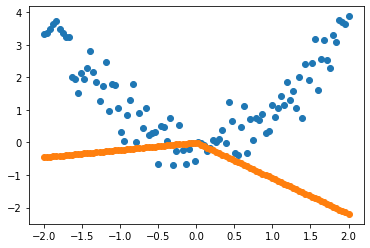

In [5]:
x = np.linspace(-2, 2, 100).reshape(-1, 1)
y = x**2 + 0.5 * np.random.randn(100, 1)
pred = l2(l1(x))
plt.scatter(x, y); 
plt.scatter(x, pred);

In [6]:
mse = MSE()

In [7]:
#forward
a1 = l1(x)
pred = l2(a1)
print(mse(pred, y))

6.803173454751562


In [8]:
# backward
dpred = mse.bwd(pred, y)
dw2, db2, da1 = l2.bwd(dpred, pred, a1)
dw1, db1, _ = l1.bwd(da1, a1, x)

In [9]:
dpred.shape, a1.shape

((100, 1), (100, 4))

In [10]:
#update params
l2.w -= 0.1 * dw2
l2.b -= 0.1 * db2
l1.w = l1.w - 0.1 * dw1
l1.b = l1.b - 0.1 * db1

In [11]:
def step(x, y, lr=0.1):
    #forward
    a1 = l1(x)
    pred = l2(a1)
    loss = mse(pred, y)

    #backward
    dpred = mse.bwd(pred, y)
    dw2, db2, da1 = l2.bwd(dpred, pred, a1)
    dw1, db1, _ = l1.bwd(da1, a1, x)
    
    #update params
    l2.w -= lr*dw2
    l2.b -= lr*db2
    l1.w = l1.w - lr*dw1
    l1.b = l1.b - lr*db1
    return loss

In [12]:
for i in range(200):
    loss = step(x, y, 0.2)
    if i%10==0: print(loss)

1.742423633698662
0.4279119791700336
0.2839875086383362
0.26104647330827346
0.2558480796153742
0.2533863349648225
0.25161345805444135
0.2497927426557769
0.24847690359646488
0.24763750753135771
0.24534572226350554
0.24003221507782144
0.23654896343414358
0.2348232219921095
0.23357554650734103
0.23266246026984636
0.23164222941631757
0.23043668856157073
0.2300071984571435
0.22988433918968326


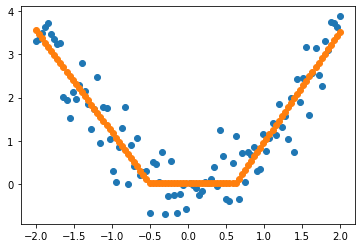

In [13]:
plt.scatter(x, y); plt.scatter(x, l2(l1(x)))

# torch custom autograd

In [14]:
import torch
from torch import nn
from torch.autograd import Function

In [15]:
class _Linear(Function):
    
    @staticmethod
    def forward(ctx, x, w, b):
        ctx.save_for_backward(x, w, b)
        return x@w + b
    
    @staticmethod
    def backward(ctx, dout):
        x,w,b = ctx.saved_tensors
        dw = x.T @ dout
        db = dout.sum(dim=0)
        dx = dout @ w.T
        return dx, dw, db
    
linear = _Linear.apply

In [16]:
class Linear(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        self.w = nn.Parameter(torch.randn(ni, no))
        self.b = nn.Parameter(torch.zeros(no))
        
    def forward(self, x):
        return linear(x, self.w, self.b)

In [17]:
class _ReLU(Function):
    
    @staticmethod
    def forward(ctx, x):
        out = x.clamp(0)
        ctx.save_for_backward(out)
        return out
    
    @staticmethod
    def backward(ctx, dout):
        (out, ) = ctx.saved_tensors
        return torch.where(out>0., dout, torch.zeros(1, dtype=dout.dtype))
    
relu = _ReLU.apply

In [18]:
class Relu(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return relu(x)

In [19]:
model = nn.Sequential(
    Linear(1,4),
    Relu(),
    Linear(4,1),
)

In [20]:
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [21]:
pred = model(x)
pred

tensor([[-4.4164],
        [-4.3272],
        [-4.2379],
        [-4.1487],
        [-4.0595],
        [-3.9703],
        [-3.8811],
        [-3.7918],
        [-3.7026],
        [-3.6134],
        [-3.5242],
        [-3.4350],
        [-3.3457],
        [-3.2565],
        [-3.1673],
        [-3.0781],
        [-2.9889],
        [-2.8996],
        [-2.8104],
        [-2.7212],
        [-2.6320],
        [-2.5428],
        [-2.4535],
        [-2.3643],
        [-2.2751],
        [-2.1859],
        [-2.0967],
        [-2.0074],
        [-1.9182],
        [-1.8290],
        [-1.7398],
        [-1.6506],
        [-1.5613],
        [-1.4721],
        [-1.3829],
        [-1.2937],
        [-1.2045],
        [-1.1152],
        [-1.0260],
        [-0.9368],
        [-0.8476],
        [-0.7584],
        [-0.6691],
        [-0.5799],
        [-0.4907],
        [-0.4015],
        [-0.3123],
        [-0.2230],
        [-0.1338],
        [-0.0446],
        [ 0.0000],
        [ 0.0000],
        [ 0.

In [22]:
loss = nn.MSELoss()(pred, y)

In [23]:
loss.backward()

In [24]:
class Trainer:
    
    def __init__(self, model, opt_func=torch.optim.SGD, loss_func=nn.MSELoss()):
        self.model = model
        self.opt_func = opt_func
        self.loss_func = loss_func
        
    def fit(self, x,y, n_epochs=100, lr=0.1):
        opt = self.opt_func(model.parameters(), lr=lr)

        for e in range(n_epochs):
            #forward
            pred = self.model(x)
            loss = self.loss_func(pred, y)

            if e%10==0:
                print(loss.item())

            # backward ->
            loss.backward()

            #params update
            opt.step()

            opt.zero_grad()

In [25]:
trainer = Trainer(model)

trainer.fit(x, y)

11.207376480102539
1.7155320644378662
1.6351089477539062
1.6341814994812012
1.6341708898544312
1.6341708898544312
1.6341708898544312
1.6341708898544312
1.6341708898544312
1.6341708898544312


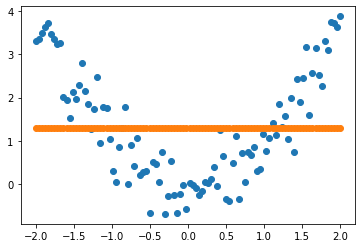

In [26]:
plt.scatter(x, y);
plt.scatter(x, model(x).detach());